## Preparing training data

The first step is loading the examples. They are split in two main folders: vehicle and non-vehicle examples. Inside each, there are more folders that actually contain the files, so we use "glob" to read all the examples from their subfolders and label them.

We read the images with mpimg since ir reads the images in as RGB, which is the same thing that the video does.

In [1]:
import cv2
import glob
import matplotlib.image as mpimg
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Load 
vehicles = []
nonvehicles = []

for fname in glob.glob('training_images\\vehicles\\*\\*.png'):
    vehicles.append(mpimg.imread(fname))

vehicles_labels = np.ones(len(vehicles))

for fname in glob.glob('training_images\\non-vehicles\\*\\*.png'):
    nonvehicles.append(mpimg.imread(fname))

nonvehicles_labels = np.zeros(len(nonvehicles))

Once we have all the examples loaded, we make sure that the data is in the expected range and that we have a balanced example set.

In [2]:
# Get information on the data
print("Maximum value of vehicle image", np.max(vehicles[0]), "and data type", vehicles[0].dtype)
print("Maximum value of non-vehicle image", np.max(nonvehicles[0]), "and data type", nonvehicles[0].dtype)
print("Number of vehicle examples", len(vehicles))
print("Number of non-vehicle examples", len(nonvehicles))

Maximum value of vehicle image 0.752941 and data type float32
Maximum value of non-vehicle image 0.811765 and data type float32
Number of vehicle examples 8792
Number of non-vehicle examples 8968


Next, the separate arrays are merged and shuffled.

In [3]:
# Preparing the data
images = np.array(vehicles + nonvehicles)
labels = np.hstack((vehicles_labels, nonvehicles_labels))
images, labels = shuffle(images, labels, random_state=23)

## Extracting features from training data

In [4]:
from skimage.feature import hog

In [5]:
def convert_color(img, target_cspace, original_cspace='RGB'):
    if target_cspace != original_cspace:
        color_conversion = eval('cv2.COLOR_' + original_cspace + '2' + target_cspace) # TODO: Validate for safety
        image = cv2.cvtColor(img, color_conversion)
    else:
        # TODO: Make sure input is in the expected range and return accordingly
        image = img * 255 # Input image comes in 0-1 range but color conversion changes it to 0-255, so we emulate
    return image
        
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    hist1 = np.histogram(img[:,:,0], bins=32, range=(0, 256))
    hist2 = np.histogram(img[:,:,1], bins=32, range=(0, 256))
    hist3 = np.histogram(img[:,:,2], bins=32, range=(0, 256))
    # Generating bin centers (the same for all colors since we use the same range and number of bins)
    bin_edges = hist1[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((hist1[0], hist2[0], hist3[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist1, hist2, hist3, bin_centers, hist_features

def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          transform_sqrt=False, 
                          visualise=True, feature_vector=feature_vec,
                          block_norm="L2-Hys")
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          transform_sqrt=False, 
                          visualise=False, feature_vector=feature_vec,
                          block_norm="L2-Hys")
        return features

In [32]:
from sklearn.preprocessing import StandardScaler

def extract_features(img, cspace='RGB', cspace_hog='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # TODO: Validate image dtype and range
    # Apply color conversion if other than 'RGB'
    #if cspace != 'RGB':
    #    color_conversion1 = eval('cv2.COLOR_RGB2' + cspace) # TODO: Validate for safety
    #    image1 = cv2.cvtColor(img, color_conversion1)
    #else:
    #    image1 = img * 255 # Input image comes in 0-1 range but color conversion changes it to 0-255, so we emulate
    image1 = convert_color(img, cspace, original_cspace='RGB')
    #if cspace_hog != 'RGB':
    #    color_conversion2 = eval('cv2.COLOR_RGB2' + cspace_hog) # TODO: Validate for safety
    #    image2 = cv2.cvtColor(img, color_conversion2)
    #else:
    #    image2 = img * 255
    image2 = convert_color(img, cspace_hog, original_cspace='RGB')
    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(image1, spatial_size)
    # Apply color_hist() to get color histogram features
    color_features = color_hist(image1, hist_bins, hist_range)[4]
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(image2.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)
    else:
        hog_features = get_hog_features(image2[:,:,hog_channel], orient,
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    # Append the new feature vector to the features list
    # Return list of feature vectors
    return np.concatenate([spatial_features, color_features, hog_features])

# For reference:
#  color_features - HSV
#  spatial_features - Any
#  hog_features - YUV(U)

# Images is an RGB image in 0-1 float32
X = np.array([extract_features(x, cspace='HSV', cspace_hog='YUV', hist_bins=64, hog_channel=1, pix_per_cell=16) for x in images]) 

In [33]:
X = X.astype(np.float64)

In [34]:
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

## Training classifier

First, the data is split into Train and Test sets.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, labels, test_size=0.2)

Next, we do a grid search on SVM parameters to find the best options. This is a time-consuming process that we will run on an AWS instance that has more computing power than our laptop.

In [36]:
import time
from sklearn.svm import SVC #, LinearSVC
# Use a linear SVC (support vector classifier)
#svc = LinearSVC()
svc = SVC(C=1, kernel='poly', gamma=0.1)
# Train the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train the SVM classifier...')

309.99 Seconds to train the SVM classifier...


In [37]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4)) # 0.9854

Test Accuracy of SVC =  0.9831


## Define vehicle search algorithm

In [38]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch1 = convert_color(img_tosearch, 'YUV')
    ctrans_tosearch2 = convert_color(img_tosearch, 'HSV')
    if scale != 1:
        imshape = ctrans_tosearch1.shape
        ctrans_tosearch1 = cv2.resize(ctrans_tosearch1, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        ctrans_tosearch2 = cv2.resize(ctrans_tosearch2, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    #ch1 = ctrans_tosearch[:,:,0]
    #ch2 = ctrans_tosearch[:,:,1]
    #ch3 = ctrans_tosearch[:,:,2]
    ch = ctrans_tosearch1[:,:,1]

    # Define blocks and steps as above
    #nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    #nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nxblocks = (ch.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    #hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    #hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    #hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog = get_hog_features(ch, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            #hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            hog_features = hog[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch2[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)[4]

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img
    


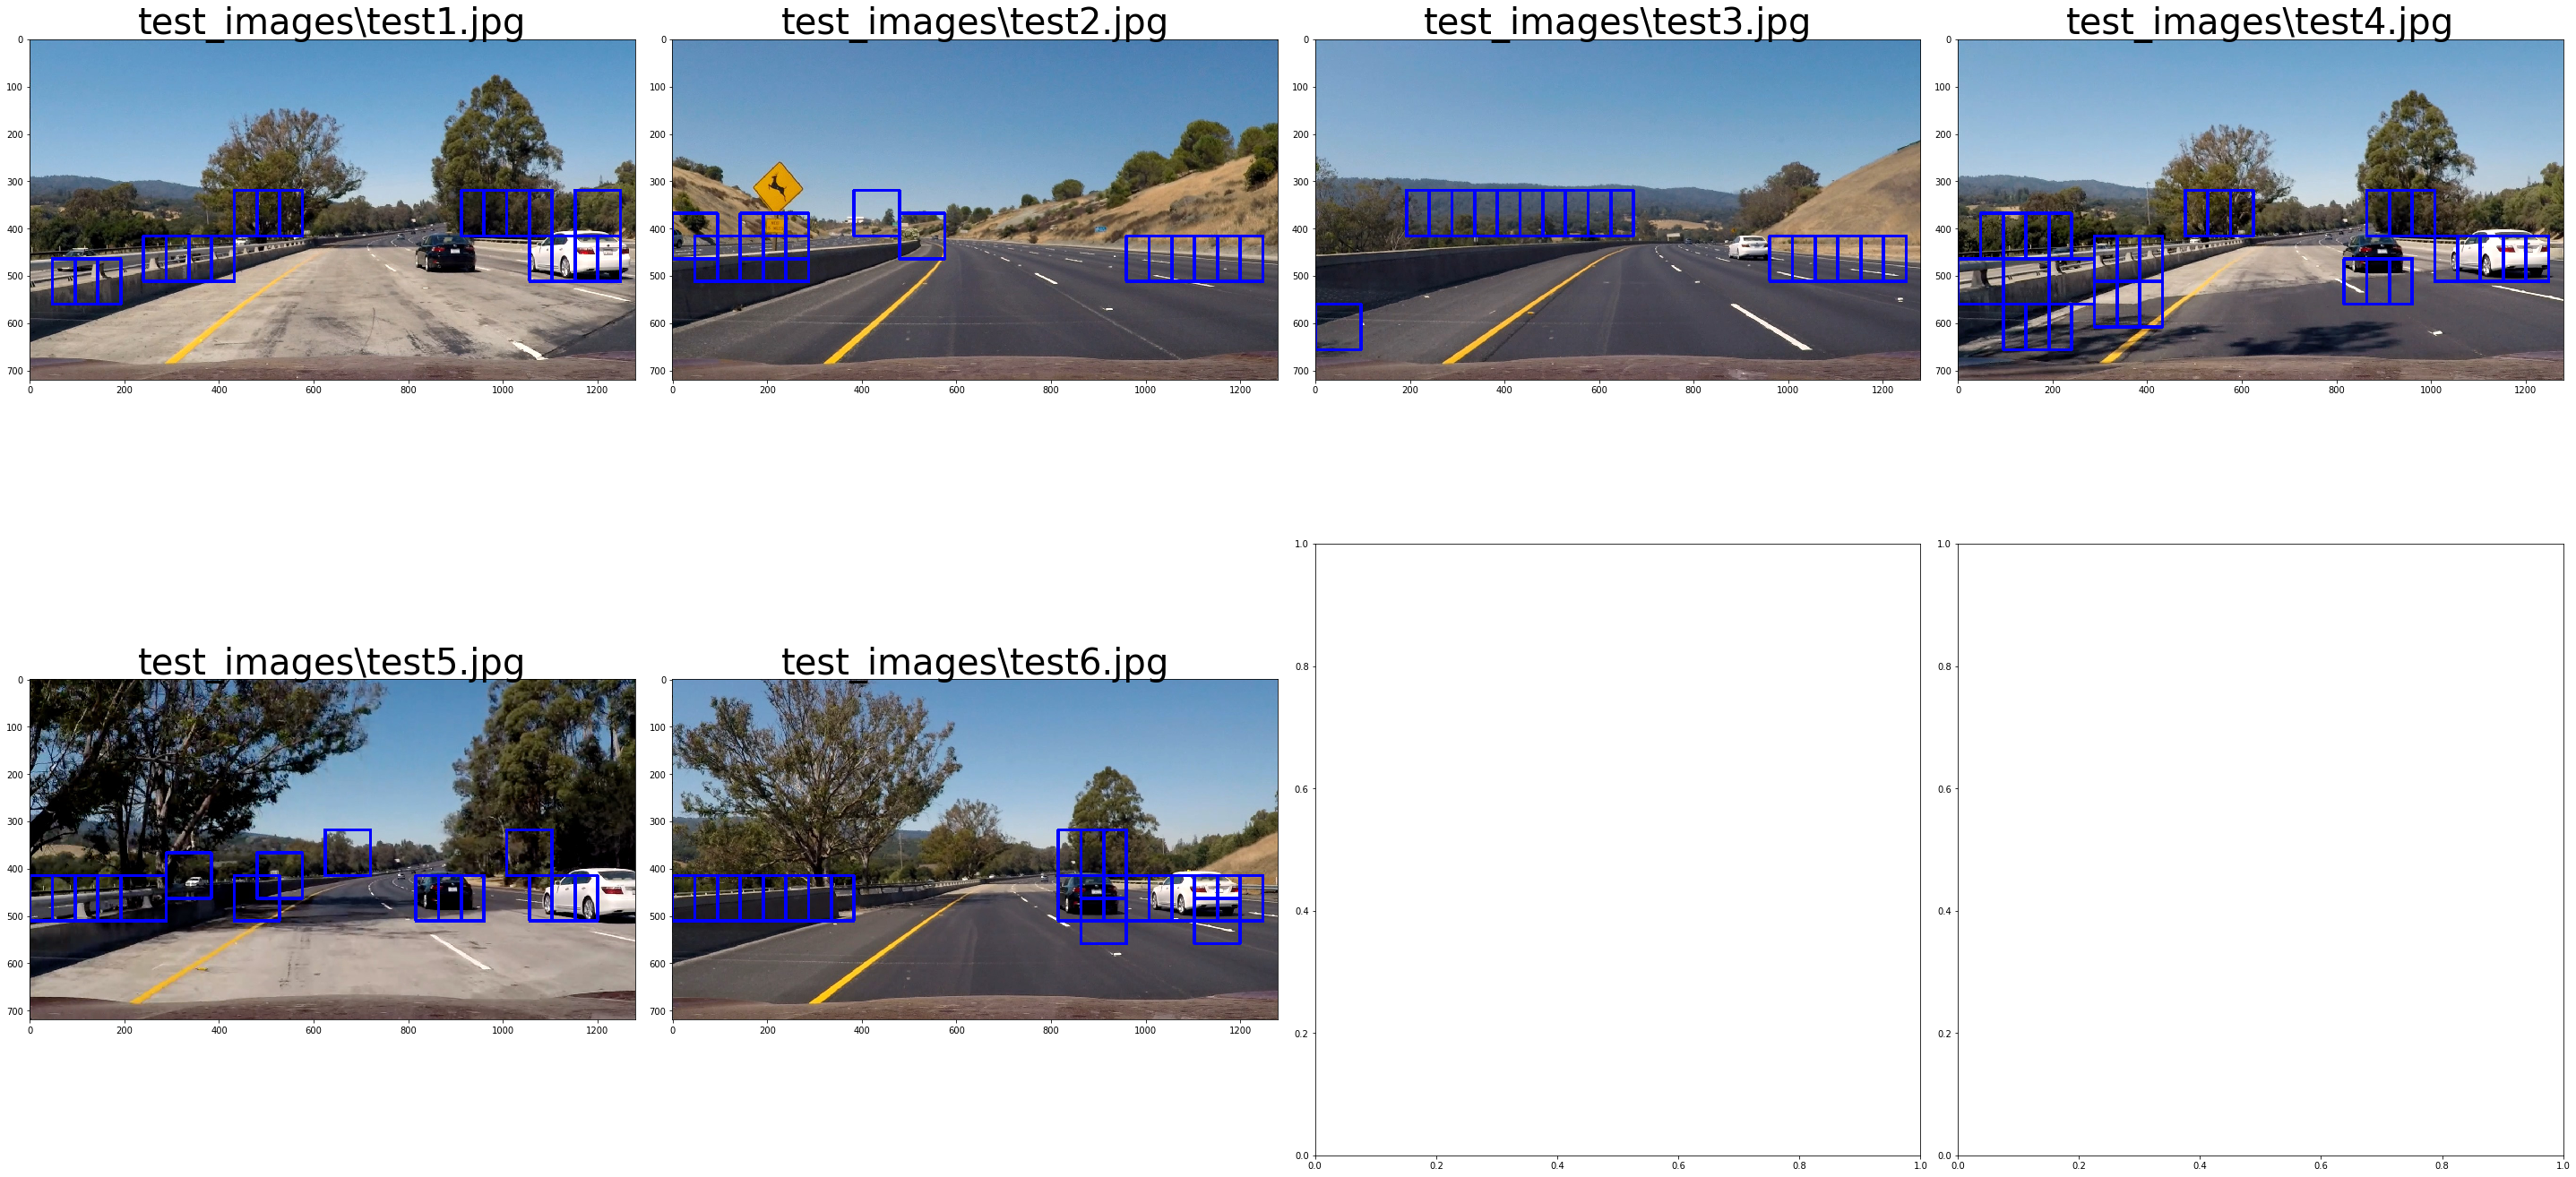

In [40]:
import math
import matplotlib.pyplot as plt
ystart = 320
ystop = 656
scale = 1.5

test_images = glob.glob('test_images\\*.jpg')
length = len(test_images)
columns = 4
rows = math.ceil(length/(columns*1.0))

f, ax = plt.subplots(rows, columns, figsize=(40,20))
ax = [c for r in ax for c in r]
f.tight_layout()

for fname, i in zip(test_images, range(length)): # Enumerate?
    image = mpimg.imread(fname)
    out_img = find_cars(image, ystart, ystop, scale, svc, X_scaler, 
                        orient=9, pix_per_cell=16, cell_per_block=2, spatial_size=(32, 32), hist_bins=64)
    ax[i].set_title(fname, fontsize=40)
    ax[i].imshow(out_img)

plt.show()

## Test vehicle search

## Redefine vehicle search with time series modification

## ...

## Camera Calibration

We have images necessary to calibrate the camera used for the project video, so we do that in order to make our predictions more reliable and as part of the normal steps of the image feed pipeline.

In [ ]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Number of X and Y points in chessboard
nx = 9
ny = 6

# Arrays to hold data for calibration
objpoints = []
imgpoints = []

# Array with objectpoints
objp = np.zeros((nx*ny, 3), np.float32)
objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

# Using range instead of glob to skip image 1 which we will use for validation
for fnum in range(2, 20):
    # Load image
    fname = 'camera_cal/calibration{}.jpg'.format(fnum)
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    found_corners, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if found_corners == True:
        # TODO: Draw and display the corners
        #cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        #plt.imshow(img)
        imgpoints.append(corners)
        objpoints.append(objp)

calibration_ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)

### Test  calibration

Where we load that first calibration image that doesn't have the last row of points (6th) visible to validate the calibration from the other 19 images. The result is somewhat there but not quite convincing... I still see some distortion in the first column.

In [ ]:
import matplotlib.image as mpimg

# Load image
fname = 'camera_cal/calibration1.jpg'
img = mpimg.imread(fname)

# Apply undistortion, with previously calculated values
undistorted = cv2.undistort(img, mtx, dist, None, mtx)

# Display result next to original
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Image Transformation Matrix

Using undistorted pictures of straight lines, calculate source points for a perspective transform. We choose a base close to the car's hood where the lines on both sides can be seen and enough distance to the horizon to provide a good warped result (enough features included) without causing too much distortion.

In [ ]:
# Source points for warping
src = np.array([[[245,680], [1060,680], [689,450], [591,450]]], dtype=np.float32)

In [ ]:
import matplotlib.image as mpimg

# Load image
fname = 'test_images/straight_lines1.jpg'
test_img = mpimg.imread(fname)
print(test_img.shape)

# Undistort
undistorted = cv2.undistort(test_img, mtx, dist, None, mtx)

# Print original next to undistorted and an overlay of the source points
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
ax3.imshow(cv2.polylines(np.copy(undistorted), src.astype('int32'), True, [255, 0, 0], 3))
ax3.set_title('Undistorted Image w/ Sources', fontsize=35)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


The source points in the second image will not match the lines, but are provided for reference...

In [ ]:
import matplotlib.image as mpimg

# Load second image, for validation
fname = 'test_images/straight_lines2.jpg'
test_img = mpimg.imread(fname)
print(test_img.shape)

# Undistort
undistorted = cv2.undistort(test_img, mtx, dist, None, mtx)

# Print original next to undistorted and an overlay of the source points
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
ax3.imshow(cv2.polylines(np.copy(undistorted), src.astype('int32'), True, [255, 0, 0], 3))
ax3.set_title('Undistorted Image w/ Sources', fontsize=35)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


Now display them warped.

In [ ]:
# Destination points
# XXX: Here 300 and 980 are references for conversion between pixels and meters
dst = np.array([[[300,720], [980,720], [980,0] ,[300,0]]], dtype=np.float32)

# Calculate transformation matrix
M = cv2.getPerspectiveTransform(src, dst)

The result presents a slight distortion of the lines towards the center of the image. This could be caused by a still imperfect distortion correction from the camera.

In [ ]:
# Load images
img1 = mpimg.imread('test_images/straight_lines1.jpg')
img2 = mpimg.imread('test_images/straight_lines2.jpg')

# Correct camera distortion
undistorted1 = cv2.undistort(img1, mtx, dist, None, mtx)
undistorted2 = cv2.undistort(img2, mtx, dist, None, mtx)

# Apply transformation
warped1 = cv2.warpPerspective(undistorted1, M, undistorted1.shape[1::-1], flags=cv2.INTER_LINEAR)
warped2 = cv2.warpPerspective(undistorted2, M, undistorted2.shape[1::-1], flags=cv2.INTER_LINEAR)
        
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()
ax1.imshow(warped1)
ax1.set_title('Warped Image 1', fontsize=30)
ax2.imshow(cv2.polylines(np.copy(warped1), dst.astype('int32'), True, [255, 0, 0], 6))
ax2.set_title('Warped Image 1 w/ Destination points', fontsize=20)
ax3.imshow(warped2)
ax3.set_title('Warped Image 2', fontsize=30)
ax4.imshow(cv2.polylines(np.copy(warped2), dst.astype('int32'), True, [255, 0, 0], 6))
ax4.set_title('Warped Image 2 w/ Destination points', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Preprocess (undistort, warp, threshold)

Select an image to extract features for, to select appropriate thresholds and values. Here, magnitude and direction are calculated for the L channel of the converted example. The base X gradient of the L channel along with the combined magnitude and direction are used as well as the X gradient for the S channel and the S channel itself, given it provides a clear picture (i.e. is not very noisy). The S channel thresholding is actually applied over an image with the exposure intensified.

In [ ]:
from skimage import exposure

fname = 'test_images/test2.jpg'
test_img = mpimg.imread(fname)
undistorted = cv2.undistort(test_img, mtx, dist, None, mtx)
warped = cv2.warpPerspective(undistorted, M, undistorted.shape[1::-1], flags=cv2.INTER_LINEAR)

gaussian_blur = 3
blurred = cv2.GaussianBlur(warped, (gaussian_blur, gaussian_blur), 0)
# Change colormap
hls = cv2.cvtColor(blurred, cv2.COLOR_RGB2HLS) #.astype(np.float)
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]

zero_base = np.zeros_like(s_channel)

sobel_kernel_size = 15
sx_thresh=(50, 100)
sy_thresh = (50, 100)
s_thresh=(200, 255)
mag_thresh=(15,255)
thresh = (np.pi/4, 3 * np.pi/4)

# L channel Sobel X
l_sobel_x = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel_size) # Take the derivative in x
abs_l_sobel_x = np.absolute(l_sobel_x) # Absolute x derivative to accentuate lines away from horizontal
scaled_x_sobel_l = np.uint8(255 * abs_l_sobel_x / np.max(abs_l_sobel_x))
l_sx_binary = np.copy(zero_base)
l_sx_binary[(scaled_x_sobel_l >= sx_thresh[0]) & (scaled_x_sobel_l <= sx_thresh[1])] = 1

# L channel Sobel Y
l_sobel_y = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel_size)
abs_l_sobel_y = np.absolute(l_sobel_y)
scaled_y_sobel_l = np.uint8(255 * abs_l_sobel_y / np.max(abs_l_sobel_y))
sy_binary = np.copy(zero_base)
sy_binary[(scaled_y_sobel_l >= sy_thresh[0]) & (scaled_y_sobel_l <= sy_thresh[1])] = 1

# L Gradient magnitude
gradient_magnitude = np.sqrt(np.power(l_sobel_x, 2) + np.power(l_sobel_y, 2))
scaled_magnitude = np.uint8(255 * gradient_magnitude/np.max(gradient_magnitude))
magnitude_mean = np.mean(scaled_magnitude);
# Zero any value that is less than mean. This reduces a lot of noise.
mag_binary = np.zeros_like(scaled_magnitude)
mag_binary[(scaled_magnitude >= mag_thresh[0]) & (scaled_magnitude <= mag_thresh[1])] = 1
#mag_binary[(scaled_magnitude >= magnitude_mean*3) & (scaled_magnitude <= 300)] = 1

# L Gradient Direction
orientation = np.arctan2(abs_l_sobel_y, abs_l_sobel_x)
orientation_binary = np.zeros_like(orientation)
orientation_binary[((orientation < thresh[0]) | (orientation > thresh[1]))] = 1
l_gradient = np.zeros_like(l_channel)
l_gradient[(orientation_binary == 1) & (mag_binary == 1)] = 1


################################################################################################
# S color channel
s_binary = np.copy(zero_base) # np.zeros_like(s_channel)
p2, p98 = np.percentile(s_channel, (2, 98)) # Calculate percentiles for each image
intensified = exposure.rescale_intensity(s_channel, in_range=(p2, p98))
s_binary[(intensified >= s_thresh[0]) & (intensified <= s_thresh[1])] = 1
print("S Color mean:", np.mean(intensified), ", median:", np.median(intensified))

# S channel Sobel X
s_sobel_x = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel_size) # Take the derivative in x
abs_s_sobel_x = np.absolute(s_sobel_x) # Absolute x derivative to accentuate lines away from horizontal
scaled_x_sobel_s = np.uint8(255 * abs_s_sobel_x / np.max(abs_s_sobel_x))
s_sx_binary = np.copy(zero_base)
s_sx_binary[(scaled_x_sobel_s >= sx_thresh[0]) & (scaled_x_sobel_s <= sx_thresh[1])] = 1
# S channel Sobel Y
s_sobel_y = cv2.Sobel(s_channel, cv2.CV_64F, 0, 1, ksize=15)
abs_s_sobel_y = np.absolute(s_sobel_y)
scaled_y_sobel_s = np.uint8(255 * abs_s_sobel_y / np.max(abs_s_sobel_y))
# S Gradient Magnitude
s_gradient_magnitude = np.sqrt(np.power(s_sobel_x, 2) + np.power(s_sobel_y, 2))
s_scaled_magnitude = np.uint8(255 * s_gradient_magnitude/np.max(s_gradient_magnitude))
s_magnitude_mean = np.mean(scaled_magnitude);
s_mag_binary = np.zeros_like(s_scaled_magnitude)
s_mag_binary[(s_scaled_magnitude >= mag_thresh[0]) & (s_scaled_magnitude <= mag_thresh[1])] = 1

# S Gradient Direction
s_orientation = np.arctan2(abs_s_sobel_y, abs_s_sobel_x)
s_orientation_binary = np.zeros_like(orientation)
s_orientation_binary[((s_orientation < thresh[0]) | (s_orientation > thresh[1]))] = 1
s_gradient = np.zeros_like(s_channel)
s_gradient[(s_orientation_binary == 1) & (s_mag_binary == 1)] = 1

s_combined = np.zeros_like(l_channel)
s_combined[(s_orientation_binary == 1) & (s_mag_binary == 1)] = 1

# Stack each channel
combined = np.zeros_like(l_channel)
if (np.mean(intensified) - np.median(intensified)) < 15:
    combined[(((orientation_binary == 1) & (mag_binary == 1)) | (l_sx_binary == 1) | (s_sx_binary == 1) | (s_binary == 1))] = 1
else:
    combined[(((orientation_binary == 1) & (mag_binary == 1)) | (l_sx_binary == 1) | (s_sx_binary == 1))] = 1

f, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(40,20))
f.tight_layout()

ax1.set_title('X axis sobel on L channel', fontsize=50)
ax1.imshow(l_sx_binary, cmap='gray')

ax2.set_title('Magnitude on L channel', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')

ax3.set_title('Magnitude + Orientation on L channel', fontsize=30)
ax3.imshow(l_gradient, cmap='gray')

ax4.set_title('S color', fontsize=50)
ax4.imshow(s_binary, cmap='gray')

ax5.set_title('X axis sobel on S channel', fontsize=50)
ax5.imshow(s_sx_binary, cmap='gray')

ax6.set_title('Magnitude on S channel', fontsize=50)
ax6.imshow(mag_binary, cmap='gray')

ax7.set_title('Magnitude + Orientation on S channel', fontsize=30)
ax7.imshow(s_gradient, cmap='gray')

ax8.set_title('Combined thresholds', fontsize=50)
ax8.imshow(combined, cmap='gray')

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Now we place that in a function using the selected thresholds as default values to be run on any grayscale image. We return only the channels we are using for the combination, which happens outside the function.

In [ ]:
def findEdges(channel, color_thresh=(200, 255), sobel_kernel_size=15, sx_thresh=(50, 100),  mag_thresh=(15, 255),
              orientation_thresh=(np.pi/4, 3*np.pi/4)):
    zero_base = np.zeros_like(channel)

    # L channel Sobel X
    sobel_x = cv2.Sobel(channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel_size) # Take the derivative in x
    abs_sobel_x = np.absolute(sobel_x) # Absolute x derivative to accentuate lines away from horizontal
    scaled_x_sobel = np.uint8(255 * abs_sobel_x / np.max(abs_sobel_x))
    sx_binary = np.copy(zero_base)
    sx_binary[(scaled_x_sobel >= sx_thresh[0]) & (scaled_x_sobel <= sx_thresh[1])] = 1
    
    # L channel Sobel Y
    sobel_y = cv2.Sobel(channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel_size)
    abs_sobel_y = np.absolute(sobel_y)
    scaled_y_sobel = np.uint8(255 * abs_sobel_y / np.max(abs_sobel_y))
    
    # L Gradient magnitude
    gradient_magnitude = np.sqrt(np.power(sobel_x, 2) + np.power(sobel_y, 2))
    scaled_magnitude = np.uint8(255 * gradient_magnitude/np.max(gradient_magnitude))
    magnitude_mean = np.mean(scaled_magnitude);
    # Zero any value that is less than mean. This reduces a lot of noise.
    mag_binary = np.zeros_like(scaled_magnitude)
    mag_binary[(scaled_magnitude >= mag_thresh[0]) & (scaled_magnitude <= mag_thresh[1])] = 1
    #mag_binary[(scaled_magnitude >= magnitude_mean*3) & (scaled_magnitude <= 300)] = 1
    
    # L Gradient Direction
    orientation = np.arctan2(abs_sobel_y, abs_sobel_x)
    orientation_binary = np.zeros_like(orientation)
    orientation_binary[((orientation < orientation_thresh[0]) | (orientation > orientation_thresh[1]))] = 1
    
    # S color channel
    binary = np.copy(zero_base)
    p2, p98 = np.percentile(channel, (2, 98)) # Calculate percentiles for each image
    intensified = exposure.rescale_intensity(channel, in_range=(p2, p98))
    if (np.mean(intensified) - np.median(intensified)) < 15:
        binary[(intensified >= color_thresh[0]) & (intensified <= color_thresh[1])] = 1
    return (binary, sx_binary, mag_binary, orientation_binary)

Now prepare the function that takes the raw image and applies the undistortion, warping and thresholding to return a combined thresholded binary image.

In [ ]:
def preprocess(img, mtx, dist, M, gaussian_blur=3, sobel_kernel_size=15, sx_thresh=(50, 100), s_thresh=(200, 255), 
               mag_thresh=(15, 255), orientation_thresh=(np.pi/4, 3*np.pi/4)):
    """Changes an RGB image to be used for line detection."""
        
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    warped = cv2.warpPerspective(undistorted, M, undistorted.shape[1::-1], flags=cv2.INTER_LINEAR)
    
    if gaussian_blur is not None and gaussian_blur > 0:
        warped = cv2.GaussianBlur(warped, (gaussian_blur, gaussian_blur), 0)
    
    # Change colormap
    hls = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Get the thresholded layers
    _, l_sx_binary, mag_binary, orientation_binary = findEdges(l_channel)
    s_binary, s_sx_binary, s_mag_binary, s_orientation_binary = findEdges(s_channel)
    
    # Combine channels
    combined = np.zeros_like(l_channel)
    combined[(((orientation_binary == 1) & (mag_binary == 1)) | (l_sx_binary == 1) | (s_sx_binary == 1) | (s_binary == 1))] = 1

    return (combined, undistorted)

And we test it out in all the images....

Some noise can still be seen and also "secondary" lines from the road's edge.

In [ ]:
import glob
images = glob.glob('test_images/*.jpg')
length = len(images)
columns = 4
rows = length//columns

f, ax = plt.subplots(rows, columns, figsize=(40,20))
ax = [c for r in ax for c in r]
f.tight_layout()

for fname, i in zip(images, range(length)): # Enumerate?
    img = mpimg.imread(fname)
    thresholded, _ = preprocess(img, mtx, dist, M) #, sx_thresh=(50, 100), s_thresh=(100, 255))
    ax[i].set_title(fname, fontsize=40)
    ax[i].imshow(thresholded, cmap='gray')

plt.show()

## Calculate lines

First we use the sliding window search to find candidate points for the lines. Those functions are straight out of the lectures. To get the left and right lines though, I am calling the function once per line and passing the source image blacked out on the wrong side (premasked images) to avoid catching points that belong to the other line.

The results are quite decent. It is important to note that they don't have to be perfect for every image if we use the last captured line as a basis for finding the next one.

In [ ]:
def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),
           max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

window_width = 100 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 120 # How much to slide left and right for searching

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    sum_ = np.sum(image[int(3*image.shape[0]/4):,:], axis=0)
    center = np.argmax(np.convolve(window,sum_))-window_width/2
    
    # Add what we found for the first layer
    window_centroids.append(center)
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best centroid by using past center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = 0 #window_width/2
        min_index = int(max(center+offset-margin,0))
        max_index = int(min(center+offset+margin,image.shape[1]))
        center = np.argmax(conv_signal[min_index:max_index])+min_index-offset
        # Add what we found for that layer
        window_centroids.append(center)

    return window_centroids

f, ax = plt.subplots(rows, columns, figsize=(40,20))
ax = [c for r in ax for c in r]
f.tight_layout()

for fname, i in zip(images, range(length)):
    img = mpimg.imread(fname)
    thresholded, _ = preprocess(img, mtx, dist, M, gaussian_blur=0) #, sx_thresh=(50, 100), s_thresh=(100, 255))
    l_premasked = np.copy(thresholded)
    l_premasked[:,thresholded.shape[1]//2:] = 0
    l_centroids = find_window_centroids(l_premasked, window_width, window_height, margin)
    r_premasked = np.copy(thresholded)
    r_premasked[:,:thresholded.shape[1]//2] = 0
    r_centroids = find_window_centroids(r_premasked, window_width, window_height, margin)

    # If we found any window centers
    if len(l_centroids) > 0 or len(r_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(thresholded)
        r_points = np.zeros_like(thresholded)

        # Go through each level and draw the windows 	
        for level in range(0,len(l_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,thresholded,l_centroids[level],level)
            r_mask = window_mask(window_width,window_height,thresholded,r_centroids[level],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage= np.dstack((thresholded, thresholded, thresholded))*255 # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((thresholded,thresholded,thresholded)),np.uint8)

    ax[i].set_title(fname, fontsize=40)
    ax[i].imshow(output, cmap='gray')

plt.show()


Now create a Line class to store the data we collect out of the video frames.

In [ ]:
from collections import deque
import math
class Line():
    def __init__(self, shape):
        # was the line detected in the last iteration?
        self.detected = False  
        self.n = 5
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        # average x values of the fitted line over the last n iterations
        self.bestx = None     
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        # polynomial coefficients for the most recent fit
        self.current_fit = [] #[np.array([False])]  
        # radius of curvature of the line in meters
        self.radius_of_curvature = None 
        # distance in meters of vehicle center from the line
        self.line_base_pos = None 
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        # full spatial range
        self.range = shape[::-1] # Reverses to have X and Y
        # x values for detected line pixels
        self.allx = None  
        # y values for detected line pixels
        self.ally = None
        self.line_ys = np.linspace(0, shape[0] - 1, num=shape[0])
        self.line_xs = None
        # conversion factors from pixelspace to worldspace
        self.ym_per_pixel = 30/720
        # 980 - 300 -> The distance between lines in pixels. They should be process constants because they
        # are used to warp the image. Might be off by ~20 pixels...
        self.xm_per_pixel = 3.7/(980-300)
        self.pixel_hist = []
        self.skipped = math.inf
        self.real_hist = []
    def _calculate_key_values(self):
        # Select a point to calculate the curvature for (the point closest to the car)
        y_eval = np.max(self.line_ys * self.ym_per_pixel)
        fit = self.real_hist[-1]
        self.radius_of_curvature = (((1 + (2 * fit[0] * y_eval + fit[1])**2)**1.5) / np.absolute(2 * fit[0])) / 1000 # In km
        # Calculate the distance (to the center of the car) while we are at it
        self.line_base_pos = abs(((self.range[0]/2) * self.xm_per_pixel) - (fit[0] * y_eval**2 + fit[1] * y_eval + fit[2]))
        #self.line_base_pos = abs(((self.range[0]/2) * self.xm_per_pixel) - fit[2]) # At Y = 0
    def find(self, x, y):
        self.detected = False
        if len(x) > 0: # TODO: Greater than?? How many points are useful to do the regression?
            self.skipped = 0
            self.allx = x
            self.ally = y
            # Fit a quadratic curve to our point coordinates
            pixel_fit = np.polyfit(y, x, 2)
            # diff = np.abs(pixel_fit - self.current_fit) # TODO: Should we complain if the line fit changes too much?
            self.detected = True
            self.pixel_hist.append(pixel_fit)
            if len(self.pixel_hist) > self.n:
                self.pixel_hist = self.pixel_hist[1:]
            real_fit = np.polyfit(y * self.ym_per_pixel, x * self.xm_per_pixel, 2)
            self.real_hist.append(real_fit)
            # Store coefficients
            self.current_fit = pixel_fit
            if len(self.current_fit) > 0:
                # Average our fits:
                self.best_fit = np.mean(self.pixel_hist, axis=0)
            else:
                # Use the one we currently have
                self.best_fit = self.current_fit
            # Create a line that we can draw
            self.line_xs = self.best_fit[0]*self.line_ys**2 + self.best_fit[1]*self.line_ys + self.best_fit[2]
            # With our line, get the curvature and distance to center
            self._calculate_key_values()
        else:
            self.skipped += 1

        

Now we calculate the lines for our selected example.

In [ ]:
thresholded, _ = preprocess(test_img, mtx, dist, M) #, gaussian_blur=0, sx_thresh=(50, 100), s_thresh=(100, 255))

# Create our two line abstractions
left = Line(thresholded.shape)
right = Line(thresholded.shape)

# Extract the points from the image halves
l_premasked = np.copy(thresholded)
l_premasked[:,thresholded.shape[1]//2:] = 0
l_centroids = find_window_centroids(l_premasked, window_width, window_height, margin)

# If we found any window centers
if len(l_centroids) > 0:
    # Points used to draw all the left windows
    l_points = np.zeros_like(thresholded)
    # Go through each level and draw the windows 
    for level in range(0,len(l_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,thresholded,l_centroids[level],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) & (thresholded == 1)) ] = 255
        
r_premasked = np.copy(thresholded)
r_premasked[:,:thresholded.shape[1]//2] = 0
r_centroids = find_window_centroids(r_premasked, window_width, window_height, margin)

if len(r_centroids) > 0:
    r_points = np.zeros_like(thresholded)
    for level in range(0,len(r_centroids)):
        r_mask = window_mask(window_width,window_height,thresholded,r_centroids[level],level)
        r_points[(r_points == 255) | ((r_mask == 1) & (thresholded == 1)) ] = 255
        
l_indexes = l_points.nonzero()
left.find(l_indexes[1], l_indexes[0])

r_indexes = r_points.nonzero()
right.find(r_indexes[1], r_indexes[0])

## Post process (draw, unwarp, distort, overlay)

Now we take steps to make use of the lines we found.

In [ ]:
line_overlay = np.zeros_like(thresholded, dtype=np.uint8)
# Draw both lines as a shape on an empty canvas
for i in range(line_overlay.shape[0]):
    line_overlay[i,max(int(left.line_xs[i]),0):int(right.line_xs[i])] = 255
plt.imshow(line_overlay, cmap='gray')
#numpy.put(a, ind, 255, mode='clip')

In [ ]:
# Use the inverse flag instead of recalculating a matrix
unwarped_mask = cv2.warpPerspective(line_overlay, M, line_overlay.shape[1::-1], flags=(cv2.INTER_LINEAR|cv2.WARP_INVERSE_MAP))
x = cv2.merge((np.zeros_like(unwarped_mask), unwarped_mask, np.zeros_like(unwarped_mask)))
plt.imshow(cv2.addWeighted(undistorted, 1, x, 0.3, 0))

Now define it as a function.

In [ ]:
def postprocess(target, left_line, right_line):
    line_overlay = np.zeros_like(target)
    thickness = 10
    offset = thickness//2
    # Draw both lines on empty canvas
    #line_overlay[left_line.ally, left_line.allx,0] = 255 # The left lane
    #line_overlay[right_line.ally, right_line.allx,2] = 255 # The right lane
    # TODO: There must be obviously a better way instead of a loop. Something along the lines of np.put.
    for i in range(line_overlay.shape[0]):
        line_overlay[i, max(int(left_line.line_xs[i]),0):int(right_line.line_xs[i]),1] = 255 # The polygon
        #line_overlay[i, max(int(left_line.line_xs[i])-offset,0):min(int(left_line.line_xs[i])+offset,line_overlay.shape[1]),0] = 255 # The left line
        #line_overlay[i, max(int(right_line.line_xs[i])-offset,0):min(int(right_line.line_xs[i])+offset,line_overlay.shape[1]),2] = 255 # The right line
    unwarped_mask = cv2.warpPerspective(line_overlay, M, line_overlay.shape[1::-1], flags=(cv2.INTER_LINEAR|cv2.WARP_INVERSE_MAP))
    masked = cv2.addWeighted(target, 1, unwarped_mask, 0.3, 0)
    # Average the curvature to avoid having to display to values and hopefully make the display more stable.
    curvature_text = "Radius of curvature: {:.2} (km)".format((left.radius_of_curvature + right.radius_of_curvature)/2.0)
    cv2.putText(masked, curvature_text, (20,50), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255), 3)
    distance_text = "Distance to center of lane: {:.2} (m)".format(left.line_base_pos - ((left.line_base_pos + right.line_base_pos) / 2.0))
    cv2.putText(masked, distance_text, (20,90), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255), 3)
    return masked

## Test (apply pipeline to all test images)

Here we can see how the initial window search takes us close but more than one image is needed to fine tune the line and inherent calculations (curvature and distance to center).

In [ ]:
import glob
images = glob.glob('test_images/*.jpg')
length = len(images)

f, ax = plt.subplots(rows, columns, figsize=(40,20))
ax = [c for r in ax for c in r] # Flatten
f.tight_layout()

for fname, i in zip(images, range(length)): # Enumerate?
    img = mpimg.imread(fname)
    thresholded, undistorted = preprocess(img, mtx, dist, M) #, sx_thresh=(50, 100), s_thresh=(100, 255))
    # Since we use different images each time, reset the lines
    left = None
    right = None
    # In case we already have a line to use as base, we find all non-zero values
    nonzero = thresholded.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    
    # Instantiate Line classes with the size of the input
    if left is None:
        left = Line(thresholded.shape)
    if right is None:
        right = Line(thresholded.shape)
    
    # If we have not found a line the last N times, we search again
    if left.skipped > 5:
        # Copy the source
        l_points = np.zeros_like(thresholded)
        l_premasked = np.copy(thresholded)
        # Use only left pixels
        l_premasked[:,thresholded.shape[1]//2:] = 0
        l_centroids = find_window_centroids(l_premasked, window_width, window_height, margin)
        if len(l_centroids) > 0:
            for level in range(0,len(l_centroids)):
                # Window_mask is a function to draw window areas but we use it to find points that fall in the windows
                l_mask = window_mask(window_width,window_height,thresholded,l_centroids[level],level)
                l_points[(l_points == 255) | ((l_mask == 1) & (thresholded == 1))] = 255
            lefty,leftx = l_points.nonzero()
    else:
        # Use all non-zero points around the current line as source for the new line
        left_lane_inds = ((nonzerox > (left.best_fit[0]*(nonzeroy**2) + left.best_fit[1]*nonzeroy + 
                        left.best_fit[2] - margin)) & (nonzerox < (left.best_fit[0]*(nonzeroy**2) + 
                        left.best_fit[1]*nonzeroy + left.best_fit[2] + margin)))
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
    
    if right.skipped > 5:
        r_points = np.zeros_like(thresholded)
        r_premasked = np.copy(thresholded)
        r_premasked[:,:thresholded.shape[1]//2] = 0
        r_centroids = find_window_centroids(r_premasked, window_width, window_height, margin)
        if len(r_centroids) > 0:
            for level in range(0,len(r_centroids)):
                r_mask = window_mask(window_width,window_height,thresholded,r_centroids[level],level)
                r_points[(r_points == 255) | ((r_mask == 1) & (thresholded == 1))] = 255
            righty,rightx = r_points.nonzero()
    else:
        right_lane_inds = ((nonzerox > (right.best_fit[0]*(nonzeroy**2) + right.best_fit[1]*nonzeroy + 
                        right.best_fit[2] - margin)) & (nonzerox < (right.best_fit[0]*(nonzeroy**2) + 
                        right.best_fit[1]*nonzeroy + right.best_fit[2] + margin)))
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
    
    left.find(leftx, lefty)
    right.find(rightx, righty)

    img2 = postprocess(undistorted, left, right)
    ax[i].set_title(fname, fontsize=40)
    ax[i].imshow(img2)

plt.show()

## Apply

Defines the function used to process each image and executes it on the video. A key part of the process is searching the points of the current frame using the line found in the last frame (unless we have not found any points for the last five frames and we have to search again).

In [ ]:
# Assignation is performed once we know the shape of the image we are dealing with
left = None
right = None
def process_image(image):
    # TODO: Get rid of globals
    global left
    global right
    thresholded, undistorted = preprocess(image, mtx, dist, M, sx_thresh=(50, 100), s_thresh=(100, 255))

    nonzero = thresholded.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    
    if left is None:
        left = Line(thresholded.shape)
    if right is None:
        right = Line(thresholded.shape)
    
    if left.skipped > 5:
        l_points = np.zeros_like(thresholded)
        l_premasked = np.copy(thresholded)
        l_premasked[:,thresholded.shape[1]//2:] = 0
        l_centroids = find_window_centroids(l_premasked, window_width, window_height, margin)
        if len(l_centroids) > 0:
            for level in range(0,len(l_centroids)):
                # Window_mask is a function to draw window areas
                l_mask = window_mask(window_width,window_height,thresholded,l_centroids[level],level)
                l_points[(l_points == 255) | ((l_mask == 1) & (thresholded == 1))] = 255
            lefty,leftx = l_points.nonzero()
    else:
        left_lane_inds = ((nonzerox > (left.best_fit[0]*(nonzeroy**2) + left.best_fit[1]*nonzeroy + 
                        left.best_fit[2] - margin)) & (nonzerox < (left.best_fit[0]*(nonzeroy**2) + 
                        left.best_fit[1]*nonzeroy + left.best_fit[2] + margin)))
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
    
    if right.skipped > 5:
        r_points = np.zeros_like(thresholded)
        r_premasked = np.copy(thresholded)
        r_premasked[:,:thresholded.shape[1]//2] = 0
        r_centroids = find_window_centroids(r_premasked, window_width, window_height, margin)
        if len(r_centroids) > 0:
            for level in range(0,len(r_centroids)):
                r_mask = window_mask(window_width,window_height,thresholded,r_centroids[level],level)
                r_points[(r_points == 255) | ((r_mask == 1) & (thresholded == 1))] = 255
            righty,rightx = r_points.nonzero()
    else:
        right_lane_inds = ((nonzerox > (right.best_fit[0]*(nonzeroy**2) + right.best_fit[1]*nonzeroy + 
                        right.best_fit[2] - margin)) & (nonzerox < (right.best_fit[0]*(nonzeroy**2) + 
                        right.best_fit[1]*nonzeroy + right.best_fit[2] + margin)))
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
    
    left.find(leftx, lefty)
    right.find(rightx, righty)

    return postprocess(undistorted, left, right)

In [ ]:
# Load the videoclip
from moviepy.editor import VideoFileClip
from IPython.display import HTML
output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4") #.subclip(31,32)

In [ ]:
# Process the video frame by frame and save it
output_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)
clip1.reader.close()
clip1.audio.reader.close_proc()

In [ ]:
# Display it in the notebook
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))